## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [3]:
!wget $data -O course_lead_scoring.csv

--2025-10-16 19:53:47--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
connected. to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 
200 OKequest sent, awaiting response... 
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.03s   

2025-10-16 19:53:47 (3.00 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [4]:
df = pd.read_csv('course_lead_scoring.csv')

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [5]:
# Separate columns by type
categorical_cols = df.select_dtypes(include=['object']).columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Replace missing values
df[categorical_cols] = df[categorical_cols].fillna('NA')
df[numeric_cols] = df[numeric_cols].fillna(0.0)

# Confirm that there are no more missing values
print("\nMissing values after replacement:")
print(df.isnull().sum())

# Define features (X) and target (y) # Target: 'converted' → 1 if signed up, 0 otherwise
X = df.drop(columns=['converted'])
y = df['converted']

# Split the dataset, First split into 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

# Then split temp into 20% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

# Print results
print("\nDataset split sizes:")
print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")


Missing values after replacement:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

Dataset split sizes:
Train: (877, 8)
Validation: (292, 8)
Test: (293, 8)


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

# Precision & Recall
p = tp / (tp + fp)
p

r = tp / (tp + fn)
r

#ROC Curves TPR and FRP
tpr = tp / (tp + fn)
tpr

fpr = fp / (fp + tn)
fpr

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

ROC AUC

In [6]:
from sklearn.metrics import roc_auc_score

df_train = X_train.copy()
df_train['converted'] = y_train

numeric_features = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income'
]

auc_scores = {}

for feature in numeric_features:
    # Compute ROC AUC using this feature as the score
    auc = roc_auc_score(y_train, df_train[feature])
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feature])
        print(f"{feature}: inverted (original AUC < 0.5)")
    
    auc_scores[feature] = auc
    print(f"{feature}: AUC = {auc:.2f}")

# Find the variable with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
print("\nThe numerical variable with the highest AUC is:", best_feature)

lead_score: AUC = 0.61
number_of_courses_viewed: AUC = 0.76
interaction_count: AUC = 0.72
annual_income: AUC = 0.55

The numerical variable with the highest AUC is: number_of_courses_viewed


lead_score: AUC = 0.83
number_of_courses_viewed: AUC = 0.64
interaction_count: AUC = 0.70
annual_income: inverted (original AUC < 0.5)
annual_income: AUC = 0.59

The numerical variable with the highest AUC is: lead_score

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

dv = DictVectorizer(sparse=False)

# X_train_enc → das Ergebnis, das vollständig numerisch ist, sodass der LogisticRegression-Algorithmus es verarbeiten kann
X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
X_val_enc = dv.transform(X_val.to_dict(orient='records'))

# Train Logistic Regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_enc, y_train)

# Predict probabilities and compute AUC
y_pred_val = model.predict_proba(X_val_enc)[:, 1]
auc_val = roc_auc_score(y_val, y_pred_val)

print(f"Validation AUC: {auc_val:.2f}")

Validation AUC: 0.87


Validation AUC: 0.72

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

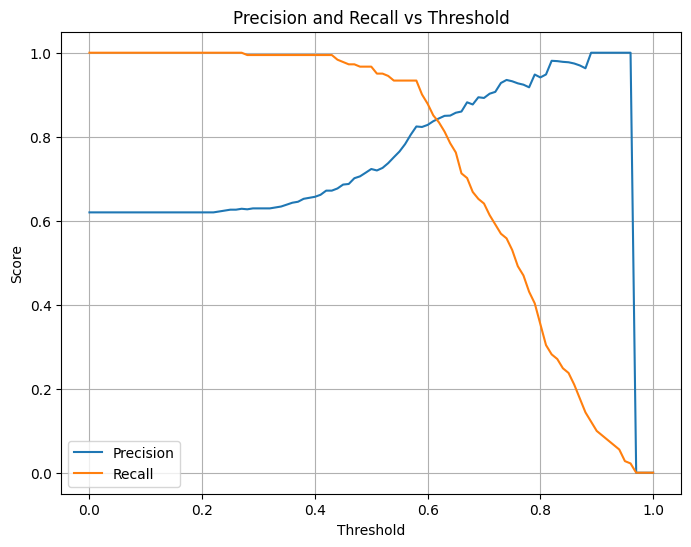

Precision and recall intersect at threshold ≈ 0.970


In [9]:
# y_pred_val: predicted probabilities from your trained logistic regression
# y_val: true labels

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_thresh = (y_pred_val >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_thresh))

# Convert to numpy arrays for convenience
precisions = np.array(precisions)
recalls = np.array(recalls)

# Plot precision-recall curves
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find threshold where precision and recall are closest (intersection)
diff = np.abs(precisions - recalls)
idx_intersect = np.argmin(diff)
threshold_intersect = thresholds[idx_intersect]

print(f"Precision and recall intersect at threshold ≈ {threshold_intersect:.3f}")

Intersection ≈ 0.345

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [10]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_pred_val >= t).astype(int)
    p = precision_score(y_val, y_pred_thresh, zero_division=0)
    r = recall_score(y_val, y_pred_thresh)
    if p + r == 0:
        f1 = 0.0
    else:
        f1 = 2 * (p * r) / (p + r)
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)

# Find threshold where F1 is maximal
idx_max_f1 = np.argmax(f1_scores)
threshold_max_f1 = thresholds[idx_max_f1]

print(f"Maximum F1 occurs at threshold ≈ {threshold_max_f1:.2f}")

Maximum F1 occurs at threshold ≈ 0.58


Maximum F1 occurs at threshold ≈ 0.34

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [11]:
from sklearn.model_selection import KFold

# Assume df_full_train is your training dataset (after cleaning, missing values handled)
# and target is 'converted'

df_full_train = df.copy() 

X_full_train = df_full_train.drop(columns=['converted'])
y_full_train = df_full_train['converted']

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_index, val_index in kf.split(X_full_train):
    X_train_fold, X_val_fold = X_full_train.iloc[train_index], X_full_train.iloc[val_index]
    y_train_fold, y_val_fold = y_full_train.iloc[train_index], y_full_train.iloc[val_index]
    
    # One-hot encoding using DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train_enc = dv.fit_transform(X_train_fold.to_dict(orient='records'))
    X_val_enc = dv.transform(X_val_fold.to_dict(orient='records'))
    
    # Train logistic regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_enc, y_train_fold)
    
    # Predict probabilities and compute AUC
    y_pred_val = model.predict_proba(X_val_enc)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_val)
    auc_scores.append(auc)

# Compute mean and standard deviation
auc_mean = np.mean(auc_scores)
auc_std = np.std(auc_scores)

print(f"AUC scores across folds: {auc_scores}")
print(f"Mean AUC: {auc_mean:.3f}")
print(f"Standard deviation of AUC: {auc_std:.3f}")

AUC scores across folds: [0.8172202350536536, 0.7792846497764531, 0.8309278350515464, 0.8675988428158148, 0.8093413173652695]
Mean AUC: 0.821
Standard deviation of AUC: 0.029


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [12]:
# Use the cleaned full training dataset
X_full_train = df_full_train.drop(columns=['converted'])
y_full_train = df_full_train['converted']

# Hyperparameter candidates
C_values = [0.000001, 0.001, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

for C in C_values:
    auc_scores = []
    
    for train_index, val_index in kf.split(X_full_train):
        X_train_fold, X_val_fold = X_full_train.iloc[train_index], X_full_train.iloc[val_index]
        y_train_fold, y_val_fold = y_full_train.iloc[train_index], y_full_train.iloc[val_index]
        
        # One-hot encoding
        dv = DictVectorizer(sparse=False)
        X_train_enc = dv.fit_transform(X_train_fold.to_dict(orient='records'))
        X_val_enc = dv.transform(X_val_fold.to_dict(orient='records'))
        
        # Train logistic regression
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_enc, y_train_fold)
        
        y_pred_val = model.predict_proba(X_val_enc)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_val)
        auc_scores.append(auc)
    
    mean_auc = np.round(np.mean(auc_scores), 3)
    std_auc = np.round(np.std(auc_scores), 3)
    results.append((C, mean_auc, std_auc))
    print(f"C={C}: Mean AUC={mean_auc}, Std={std_auc}")

# Select best C
# First, highest mean. If tie, lowest std. If still tie, smallest C.
results_sorted = sorted(results, key=lambda x: (-x[1], x[2], x[0]))
best_C = results_sorted[0][0]
print(f"\nBest C according to CV: {best_C}")

C=1e-06: Mean AUC=0.549, Std=0.03
C=0.001: Mean AUC=0.862, Std=0.024
C=1: Mean AUC=0.821, Std=0.029

Best C according to CV: 0.001


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one